## Constructing a Knowledge Base from Real World Sources

In [17]:
from prophet import Prophet
import pandas as pd

In [18]:
# plug in some CPI data
cpi_food = pd.DataFrame({
    "ds": ["2019-01-01", "2020-01-01", "2021-01-01", "2022-01-01", "2023-01-01", "2024-01-01"],
    "y": [84.449, 86.018, 87.266, 91.902, 97.24, 100],
})

cpi_food

,ds,y
0,2019-01-01,84.449
1,2020-01-01,86.018
2,2021-01-01,87.266
3,2022-01-01,91.902
4,2023-01-01,97.240
5,2024-01-01,100.000


In [19]:
m = Prophet(yearly_seasonality=False)
m = m.fit(cpi_food)
future = m.make_future_dataframe(periods=2, freq='YS')
forecast = m.predict(future)
forecast[["ds", "yhat_lower", "yhat_upper", "yhat"]]

10:34:38 - cmdstanpy - INFO - Chain [1] start processing
10:34:38 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat_lower,yhat_upper,yhat
0,2019-01-01,83.721159,84.997090,84.323800
1,2020-01-01,85.402972,86.723079,86.023141
2,2021-01-01,87.090420,88.311243,87.728641
3,2022-01-01,91.400382,92.649719,91.997554
4,2023-01-01,95.608721,96.853412,96.266467
5,2024-01-01,99.890562,101.175372,100.535380
6,2025-01-01,104.001730,105.681544,104.815989
7,2026-01-01,107.420544,110.727171,109.084902


In [20]:
# 2025 80% interval: 103.98 - 105.59
# 2026 80% interval: 107.54 - 110.75

### Using CPI to model changes in price
This will help us predict future expenditures

In [21]:
mth2num = {
    "Jan": "01",
    "Feb": "02",
    "Mar": "03",
    "Apr": "04",
    "May": "05",
    "Jun": "06",
    "Jul": "07",
    "Aug": "08",
    "Sep": "09",
    "Oct": "10",
    "Nov": "11",
    "Dec": "12"
}
def rename_month(x):
    if x == "Data Series":
        return x
    year, mth = x.strip().split(" ")
    return f"{year}-{mth2num[mth]}-01"

df = pd.read_csv("data/cpi_data.csv")
df["Data Series"] = df["Data Series"].str.strip()
df = df.rename(mapper=rename_month, axis='columns')
df = df.replace(to_replace="na", value=None)

def get_ds(series_name):
    return df[df["Data Series"] == series_name].reset_index(drop=True) \
                .drop(columns=["Data Series"]) \
                .T.reset_index().rename(columns={"index": "ds", 0: "y"}) \
                .dropna()

cpi_food = get_ds("Food")
cpi_utilities = get_ds("Utilities & Other Fuels")
cpi_recreation = get_ds("Recreation, Sport & Culture")
# maybe need to handle transport separately because it may not follow the cpi exactly
# (some ppl take public transport, some ppl take a lot of private hire, some ppl drive, soooo ??)
cpi_petrol = get_ds("Petrol")
cpi_public_transport = get_ds("Land Transport Services")

### Knowledge Base with Predictions
- takes in some initial values, and uses the Prophet model along with CPI data to predict movements in expenditure
- probably works best with food CPI data because food data has a good trend
- other data (e.g. utilities, transport) not so good trend because they are affected by external factors (e.g. oil prices, government policies, etc.)
- but the model tries to make a best guess based on CPI data

In [22]:

class PredictionEngine():
    interval_width = 0.8 # make predictions with 80% confidence interval
    current_expenditure = {}
    m_food = Prophet(yearly_seasonality=True, interval_width=interval_width)
    m_util = Prophet(yearly_seasonality=True, interval_width=0.6)
    m_tran = Prophet(yearly_seasonality=False, interval_width=0.6) # yearly seasonality is not relevant for transport
    m_petr = Prophet(yearly_seasonality=True, interval_width=0.6)
    m_recr = Prophet(yearly_seasonality=True, interval_width=0.6)

    def __init__(self, food, transport, use_public_transport, utilities, discretionary, invest, take_home):
        self.current_expenditure["food"] = food
        self.current_expenditure["transport"] = transport
        self.current_expenditure["utilities"] = utilities
        self.current_expenditure["discretionary"] = discretionary
        self.use_public_transport = use_public_transport
        self.take_home = take_home
        # fit models
        self.m_food.fit(cpi_food)
        self.m_util.fit(cpi_utilities)
        self.m_tran.fit(cpi_public_transport)
        self.m_petr.fit(cpi_petrol)
        self.m_recr.fit(cpi_recreation)

    # helper function, computes the gap in months between today and the date given
    def calculate_gap_in_months(self, date_str):
        year, month, day = date_str.split("-")
        today_year, today_month = self.get_today_month_year()
        # compute gap in months
        gap = (today_year - int(year)) * 12 + abs(int(month) - today_month)
        return gap
    
    # helper function, computes today's year and month
    def get_today_month_year(self):
        # today = pd.to_datetime("today")
        # today_year = today.year
        # today_month = today.month
        # return today_year, today_month
        # for testing purposes, we will just use a fixed date
        today_year = 2026
        today_month = 10
        return today_year, today_month

    # takes in 2 input: category and number of months from now, returns: probability and prediction of price
    def predict_expenditures(self, category, num_mths):
        match category:
            case "food":
                m = self.m_food
                last_recorded_month = cpi_food["ds"].iloc[0]
            case "transport":
                m = self.m_tran if self.use_public_transport else self.m_petr
                last_recorded_month = cpi_public_transport["ds"].iloc[0] if self.use_public_transport else cpi_petrol["ds"].iloc[0]
            case "utilities":
                m = self.m_util
                last_recorded_month = cpi_utilities["ds"].iloc[0]
            case "discretionary":
                m = self.m_recr
                last_recorded_month = cpi_recreation["ds"].iloc[0]
        # compute how much to add to the last recorded month, to get prediction for the nth month
        gap = self.calculate_gap_in_months(last_recorded_month)
        num_mths += gap
        
        future = m.make_future_dataframe(periods=num_mths, freq='MS')
        forecast = m.predict(future)

        # compute change in price for each month compared to the current month
        today_year, today_month = self.get_today_month_year()
        today = f"{today_year}-{str(today_month).zfill(2)}-01"
        cpi_base = forecast["yhat"].loc[forecast["ds"] == today].values[0]
        forecast["cpi_change"] = forecast["yhat"] - cpi_base
        forecast["cpi_lower"] = forecast["yhat_lower"] - cpi_base
        forecast["cpi_upper"] = forecast["yhat_upper"] - cpi_base
        # compute the predicted price for each month
        forecast["pred_price"] = self.current_expenditure[category] + (forecast["cpi_change"] / cpi_base) * self.current_expenditure[category]
        forecast["pred_price_lower"] = self.current_expenditure[category] + (forecast["cpi_lower"] / cpi_base) * self.current_expenditure[category]
        forecast["pred_price_upper"] = self.current_expenditure[category] + (forecast["cpi_upper"] / cpi_base) * self.current_expenditure[category]

        # return the predicted price for the next num_mths months
        return forecast.iloc[-(num_mths - gap):].reset_index(drop=True)
    
    # predict expenditure for a specific month, num_mths from now
    def predict_expenditure(self, category, num_mths):
        # compute the predicted expenditures for the next num_mths months
        pred = self.predict_expenditures(category, num_mths)
        # return the predicted expenditure for the last month, with the lower and upper bounds
        lower, pred, upper = pred["pred_price_lower"].iloc[-1], pred["pred_price"].iloc[-1], pred["pred_price_upper"].iloc[-1]
        return lower, pred, upper

    # predicts cumulative savings in num_mths months
    def predict_cumulative_savings(self, num_mths):
        # compute the predicted expenditure for each category
        food_pred = self.predict_expenditures("food", num_mths)
        transport_pred = self.predict_expenditures("transport", num_mths)
        utilities_pred = self.predict_expenditures("utilities", num_mths)
        discretionary_pred = self.predict_expenditures("discretionary", num_mths)

        # compute the total predicted expenditure for each month
        total_pred = food_pred["pred_price"] + transport_pred["pred_price"] + utilities_pred["pred_price"] + discretionary_pred["pred_price"]
        total_pred_lower = food_pred["pred_price_lower"] + transport_pred["pred_price_lower"] + utilities_pred["pred_price_lower"] + discretionary_pred["pred_price_lower"]
        total_pred_upper = food_pred["pred_price_upper"] + transport_pred["pred_price_upper"] + utilities_pred["pred_price_upper"] + discretionary_pred["pred_price_upper"]

        # compute the savings for each month
        savings = self.take_home - total_pred
        savings_upper = self.take_home - total_pred_lower # upper bound of savings = monthly income - lower bound of expenditure
        savings_lower = self.take_home - total_pred_upper # lower bound of savings = monthly income - upper bound of expenditure

        # compute the cumulative savings in total
        savings = savings.cumsum()
        savings_upper = savings_upper.cumsum()
        savings_lower = savings_lower.cumsum()

        return savings_lower.iloc[-1], savings.iloc[-1], savings_upper.iloc[-1]
    
    # set new values
    def set_new_values(self, food, transport, use_public_transport, utilities, discretionary, invest, take_home):
        self.current_expenditure["food"] = food
        self.current_expenditure["transport"] = transport
        self.current_expenditure["utilities"] = utilities
        self.current_expenditure["discretionary"] = discretionary
        self.use_public_transport = use_public_transport
        self.take_home = take_home
        
        
# set some initial values
state = {
    "food": 400,
    "transport": 80,
    "use_public_transport": True,
    "utilities": 200,
    "discretionary": 200,
    "invest": None,
    "take_home": 1000
}
engine = PredictionEngine(**state)
print("food expenditure on 6th month from now:")
print(engine.predict_expenditure("food", 6)) # predict the monthly food expenditure in 6 months
print("cumulative savings in 6 months:")
print(engine.predict_cumulative_savings(6)) # predict the cumulative savings in 6 months

# simulate different discretionary spending
s1 = state.copy()
s1["discretionary"] = 100
s2 = state.copy()
s2["discretionary"] = 300
s3 = state.copy()
s3["discretionary"] = 500
engine.set_new_values(**s1)
print("cumulative savings in 6 months with discretionary spending of 100:")
print(engine.predict_cumulative_savings(6))
engine.set_new_values(**s2)
print("cumulative savings in 6 months with discretionary spending of 300:")
print(engine.predict_cumulative_savings(6))
engine.set_new_values(**s3)
print("cumulative savings in 6 months with discretionary spending of 500:")
print(engine.predict_cumulative_savings(6))

# future plans ??
# add in other categories of spending
# e.g. housing / rent, monthly investments, etc.
# add in other categories of income
# e.g. dividends from investments




10:34:38 - cmdstanpy - INFO - Chain [1] start processing
10:34:38 - cmdstanpy - INFO - Chain [1] done processing
10:34:38 - cmdstanpy - INFO - Chain [1] start processing
10:34:38 - cmdstanpy - INFO - Chain [1] done processing
10:34:38 - cmdstanpy - INFO - Chain [1] start processing
10:34:38 - cmdstanpy - INFO - Chain [1] done processing
10:34:38 - cmdstanpy - INFO - Chain [1] start processing
10:34:38 - cmdstanpy - INFO - Chain [1] done processing
10:34:39 - cmdstanpy - INFO - Chain [1] start processing
10:34:39 - cmdstanpy - INFO - Chain [1] done processing


food expenditure on 6th month from now:
(np.float64(395.63117054112473), np.float64(403.5232383583886), np.float64(411.4355441577815))
cumulative savings in 6 months:
(np.float64(568.8182025661031), np.float64(684.827427729009), np.float64(797.9904963835555))
cumulative savings in 6 months with discretionary spending of 100:
(np.float64(1179.1986293389496), np.float64(1287.9066943142648), np.float64(1393.3031546725406))
cumulative savings in 6 months with discretionary spending of 300:
(np.float64(-42.254874913934145), np.float64(81.74816114375312), np.float64(204.61685383965948))
cumulative savings in 6 months with discretionary spending of 500:
(np.float64(-1266.2165857237942), np.float64(-1124.4103720267588), np.float64(-986.4725755257803))


### Influence Diagram Testing
It's possible to obtain probabilities from the knowledge base, so as to use in an influence diagram.

But honestly I have no idea what to do with this, left it in for now

In [23]:
import os

%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt
from IPython.display import display,HTML

import math

import pyagrum as gum
import pyagrum.lib.notebook as gnb

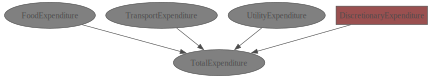

In [24]:
# Create an empty influence diagram
ie = gum.InfluenceDiagram()

# 🟢 Chance nodes
food = ie.addChanceNode(gum.LabelizedVariable("FoodExpenditure", "", 3))  # 0: Low, 1: Medium, 2: High
transport = ie.addChanceNode(gum.LabelizedVariable("TransportExpenditure", "", 3))
utility = ie.addChanceNode(gum.LabelizedVariable("UtilityExpenditure", "", 3))

# 🟦 Decision node
discretionary = ie.addDecisionNode(gum.LabelizedVariable("DiscretionaryExpenditure", "", 3))  # 0: None, 1: Some, 2: High

# 🔷 Output: Total expenditure (chance node)
total = ie.addChanceNode(gum.LabelizedVariable("TotalExpenditure", "", 3))  # 0: Low, 1: Medium, 2: High

# Add arcs (dependencies)
ie.addArc(food, total)
ie.addArc(transport, total)
ie.addArc(utility, total)
ie.addArc(discretionary, total)

# Optional: show diagram
gnb.showInfluenceDiagram(ie)
